Data for this project was taken from: http://insideairbnb.com/get-the-data.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import math
import pylab
import scipy.stats as stats
import xgboost as xg
import time
import xgboost as xgb
import keras
import pydotplus as pydot
from xgboost import XGBClassifier
from xgboost import plot_importance
from IPython.display import SVG
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
#I only used the listings.csv file for this project.
data = pd.read_csv("listings.csv")

D:\Python\envs\tensorflow-sessions\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3344,https://www.airbnb.com/rooms/3344,2.019110e+13,11/22/2019,"White House/Center City, 1 roommate",This listing is for one roommate in a 2BR/2BA ...,"You have found The One, but be sure to message...",This listing is for one roommate in a 2BR/2BA ...,none,This is the hottest neighborhood in D.C. at th...,...,f,f,moderate,f,f,2,1,1,0,0.09
1,3362,https://www.airbnb.com/rooms/3362,2.019110e+13,11/22/2019,"Convention Center Rowhouse & In Law: 2 Units, 4BR",An architect-designed rowhouse featuring a lar...,This listing features our 19th century Victori...,An architect-designed rowhouse featuring a lar...,none,NaN,...,t,f,strict_14_with_grace_period,f,f,5,5,0,0,1.33
2,3670,https://www.airbnb.com/rooms/3670,2.019110e+13,11/22/2019,Beautiful Sun-Lit U Street 1BR/1BA,Convenient location perfect for business trave...,"Sunny, bright private room. Includes a queen s...",Convenient location perfect for business trave...,none,We are nicely situated on a quiet residential ...,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,1.39
3,3686,https://www.airbnb.com/rooms/3686,2.019110e+13,11/22/2019,Vita's Hideaway,IMPORTANT NOTES * Carefully read and be sure t...,IMPORTANT NOTES * Airbnb keeps accurate track ...,IMPORTANT NOTES * Carefully read and be sure t...,none,We love that our neighborhood is up and coming...,...,f,f,moderate,f,f,2,0,2,0,0.64
4,3771,https://www.airbnb.com/rooms/3771,2.019110e+13,11/22/2019,Mt. Pleasant,"Clean, convenient and welcoming home. Bedroom...","Spacious, clean, convenient and welcoming home...","Clean, convenient and welcoming home. Bedroom...",none,NaN,...,f,f,moderate,f,f,1,0,1,0,0.01


In [4]:
data.shape

(9152, 106)

Here we see that our original data set had 9,152 rows and 106 columns. 

# DATA CLEANING

In [5]:
#All of the columns in the dataset. 
data.dtypes

id                                                int64
listing_url                                      object
scrape_id                                       float64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 106, dtype: object

106 columns is a lot to take in, and just by reading through the list we can definitely take out a vast majority of them due to the fact that it will not help in predicting Airbnb prices. 

In [6]:
data = data.drop(['id','zipcode','listing_url','name','summary','bed_type','scrape_id','last_scraped','space','description','neighborhood_overview','experiences_offered','notes','transit','access','house_rules','square_feet','interaction','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url','host_name','host_since','host_location','host_about','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_thumbnail_url','host_picture_url','host_neighbourhood','host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic','host_identity_verified','street','neighbourhood_cleansed','neighbourhood_group_cleansed','city','state','market','smart_location','country_code','country','is_location_exact','weekly_price','monthly_price','extra_people','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','has_availability','availability_60','availability_90','availability_365','calendar_last_scraped','number_of_reviews_ltm','first_review','last_review','review_scores_accuracy','review_scores_location','review_scores_value','requires_license','license','jurisdiction_names','instant_bookable','is_business_travel_ready','require_guest_profile_picture','require_guest_phone_verification','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month'], axis=1)

In [7]:
data.shape

(9152, 23)

This is much better. The number of columns changed from 106 to 23!

Now that the Data set is cleaned out, let's look for any missing values. 

In [8]:
#Shows the number of missing values within each column. This will help find out what we need to work on
for col in data.columns:
    print('Amount of Missing Values in ' + col + ':', len(data[col][data[col].isnull()]))

Amount of Missing Values in neighbourhood: 34
Amount of Missing Values in latitude: 0
Amount of Missing Values in longitude: 0
Amount of Missing Values in property_type: 0
Amount of Missing Values in room_type: 0
Amount of Missing Values in accommodates: 0
Amount of Missing Values in bathrooms: 10
Amount of Missing Values in bedrooms: 9
Amount of Missing Values in beds: 13
Amount of Missing Values in amenities: 0
Amount of Missing Values in price: 0
Amount of Missing Values in security_deposit: 2953
Amount of Missing Values in cleaning_fee: 1655
Amount of Missing Values in guests_included: 0
Amount of Missing Values in minimum_nights: 0
Amount of Missing Values in maximum_nights: 0
Amount of Missing Values in availability_30: 0
Amount of Missing Values in number_of_reviews: 0
Amount of Missing Values in review_scores_rating: 1856
Amount of Missing Values in review_scores_cleanliness: 1862
Amount of Missing Values in review_scores_checkin: 1867
Amount of Missing Values in review_scores_

Obviously there's an issue with some of the property posted. Some places have no values for beds, bedrooms, bathrooms, etc. Even with places that have the value 0 for these columns are inconsistent and should be removed. 

In [9]:
# We are going to remove all of the NaN values from the dataframe. 
original = len(data)
data = data.dropna(how='any', subset=['property_type', 'bedrooms', 'beds', 'bathrooms'])

# Changing price and cleaning fee to float. 
data['price'] = (data['price'].str.replace(r'[^-+\d.]', '').astype(float))
data['cleaning_fee'] = (data['cleaning_fee'].str.replace(r'[^-+\d.]','').astype(float))
data['security_deposit'] = (data['security_deposit'].str.replace(r'[^-+\d.]','').astype(float))

# Removing all of the rows with inconsistent values. 
#If there are 0 in accomodates, bedrooms, beds, and/or price then we remove the row
data = data[data['accommodates'] != 0]
data = data[data['bedrooms'] != 0]
data = data[data['beds'] != 0]
data = data[data['price'] != 0.00]

The next step would be to deal with cleaning_fee, security deposit, and the other columns regarding review scores. We will convert all the empty values to 0. 

In [10]:
# remove inconsistent NaN values
data = data[~data['review_scores_rating'].isnull()]
data = data[~data['review_scores_cleanliness'].isnull()]
data = data[~data['review_scores_checkin'].isnull()]
data = data[~data['review_scores_communication'].isnull()]
data['cleaning_fee'] = data['cleaning_fee'].fillna(0)
data['security_deposit'] = data['security_deposit'].fillna(0)

In [11]:
#Shows the number of missing values within each column. Going to run it a second time to make sure there are no missing values.
for col in data.columns:
    print('Amount of Missing Values in ' + col + ':', len(data[col][data[col].isnull()]))

Amount of Missing Values in neighbourhood: 0
Amount of Missing Values in latitude: 0
Amount of Missing Values in longitude: 0
Amount of Missing Values in property_type: 0
Amount of Missing Values in room_type: 0
Amount of Missing Values in accommodates: 0
Amount of Missing Values in bathrooms: 0
Amount of Missing Values in bedrooms: 0
Amount of Missing Values in beds: 0
Amount of Missing Values in amenities: 0
Amount of Missing Values in price: 0
Amount of Missing Values in security_deposit: 0
Amount of Missing Values in cleaning_fee: 0
Amount of Missing Values in guests_included: 0
Amount of Missing Values in minimum_nights: 0
Amount of Missing Values in maximum_nights: 0
Amount of Missing Values in availability_30: 0
Amount of Missing Values in number_of_reviews: 0
Amount of Missing Values in review_scores_rating: 0
Amount of Missing Values in review_scores_cleanliness: 0
Amount of Missing Values in review_scores_checkin: 0
Amount of Missing Values in review_scores_communication: 0
A

Now all the data entries have no missing values. 

In [12]:
data.shape

(6496, 23)

After cleaning the data, we went from 9,152 rows to 6,496 

This looks amazing. The only column with missing values is summary, which isn't too important because it only describes what the property is like. The other columns can compensate for that. 

Now let's deal with the categorical values.

In [13]:
data.property_type.value_counts()

Apartment             2700
House                 1435
Townhouse             1209
Condominium            525
Guest suite            390
Bed and breakfast       49
Serviced apartment      45
Loft                    40
Guesthouse              36
Other                   16
Bungalow                15
Hostel                  14
Villa                    5
Boutique hotel           4
Aparthotel               3
Boat                     2
Cottage                  2
Tiny house               2
Barn                     2
Dome house               1
Resort                   1
Name: property_type, dtype: int64

There are many different types of properties to consider when looking at the data, so we'll group some of them together in order to have less options to choose from. In this case, we will have four different properties: House, Apartment, Townhouse, and Other. 

In [14]:
#Converting any property that isn't House or Apartment to its designated property type. 
data.property_type.replace({
    'Townhouse': 'House',
    'Condominium': 'Apartment',
    'Guest suite': 'Apartment',
    'Serviced apartment': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Serviced apartment': 'House',
    'Loft': 'Apartment'  
    }, inplace=True)

# Replacing other categories with 'other'
data.loc[~data.property_type.isin(['House', 'Apartment', 'Townhouse']), 'property_type'] = 'Other'

There are a ton of amenities that we need to sort through as well, otherwise the models won't work. 

We made created a list of amenities and we are going to categorize some of them into more specific amenities. 

In [15]:
# Creating a set of all possible amenities
amenity = list(data.amenities)
amenities_string = " ".join(amenity)
#Replace some characters so that each amenity won't be an individual value, but rather have an entire list
amenities_string = amenities_string.replace('{', '')
amenities_string = amenities_string.replace('}', ',')
amenities_string = amenities_string.replace('"', '')
#Convert all amenities together to make a single list
amenities_list = [x.strip() for x in amenities_string.split(',')]
amenities_list = set(amenities_list)
amenities_list

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Amazon Echo',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Breakfast',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Central air conditioning',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Double oven',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'En suite bathroom',
 'Espresso machine',
 'Essentials',
 'Ethernet con

In [16]:
#Group items together to make it easier to identify when using neural networks
data.loc[data['amenities'].str.contains('Wide clearance to shower|Wide doorway to guest bathroom|Wide entrance|Wide entrance for guests|Wide entryway|Wide hallways'), 'Wide room'] = 1
data.loc[data['amenities'].str.contains('Private bathroom|Private entrance|Private living room'), 'Privacy'] = 1
data.loc[data['amenities'].str.contains('Dishes and silverware|Dishwasher|Double oven|Microwave|Mini fridge|Refrigerator|Stove'), 'Kitchen Equipment'] = 1
data.loc[data['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
data.loc[data['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
data.loc[data['amenities'].str.contains('Amazon Echo|Game console|Netflix|Projector and screen|Smart TV|HBO GO'), 'high_end_electronics'] = 1
data.loc[data['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
data.loc[data['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
data.loc[data['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
data.loc[data['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
data.loc[data['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
data.loc[data['amenities'].str.contains('TV|Cable TV'), 'tv'] = 1
data.loc[data['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
data.loc[data['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
data.loc[data['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
data.loc[data['amenities'].str.contains('Elevator'), 'elevator'] = 1
data.loc[data['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
data.loc[data['amenities'].str.contains('Family/kid friendly|Children|children|Crib|Baby bath|Baby monitor|Babysitter recommendations'), 'child_friendly'] = 1
data.loc[data['amenities'].str.contains('parking'), 'parking'] = 1
data.loc[data['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
data.loc[data['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
data.loc[data['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
data.loc[data['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
data.loc[data['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
data.loc[data['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
data.loc[data['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
data.loc[data['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
data.loc[data['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
data.loc[data['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
data.loc[data['amenities'].str.contains('Step-free access|Wheelchair|Accessible|Accessible-height bed|Accessible-height toilet'), 'accessible'] = 1
data.loc[data['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

D:\Python\envs\tensorflow-sessions\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [17]:
data.shape

(6496, 54)

In [18]:
# Dropping the original amenity feature
data.drop('amenities', axis=1, inplace=True)

In [19]:
data.head()

,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,...,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,accessible,event_suitable
0,Downtown/Penn Quarter,38.90126,-77.02857,Apartment,Private room,1,1.0,1.0,1.0,55.0,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,Shaw,38.91046,-77.01933,House,Entire home/apt,16,3.5,4.0,6.0,433.0,...,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2,U Street Corridor,38.91842,-77.02750,House,Private room,2,1.0,1.0,1.0,75.0,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Anacostia,38.86314,-76.98836,House,Private room,1,1.0,1.0,1.0,55.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Shaw,38.91331,-77.02436,House,Private room,2,2.5,1.0,1.0,475.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Replacing all NaN values of the new amenities columns with 0
data.fillna(0, inplace=True)

In [21]:
data.to_csv('data_clean.csv')

# Exploratory Data Analysis

Now that the data is clean, we can finally analyze the data. 

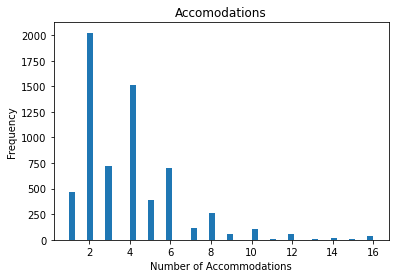

In [22]:
# visualize distribution of price (target variable)
plt.hist(data['accommodates'], bins=50)
plt.title("Accomodations")
plt.xlabel("Number of Accommodations")
plt.ylabel("Frequency")
plt.show()

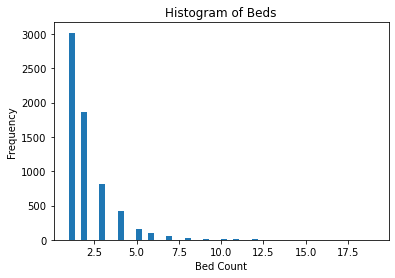

In [23]:
# visualize distribution of beds
plt.hist(data['beds'], bins=50)
plt.title("Histogram of Beds")
plt.xlabel("Bed Count")
plt.ylabel("Frequency")
plt.show()

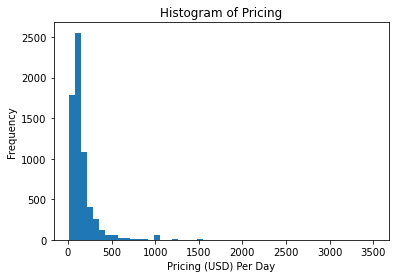

In [24]:
# visualize distribution of price (target variable)
plt.hist(data['price'], bins=50)
plt.title("Histogram of Pricing")
plt.xlabel("Pricing (USD) Per Day")
plt.ylabel("Frequency")
plt.show()

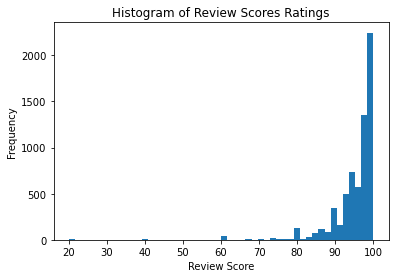

In [25]:
# visualize distribution of review scores ratings
plt.hist(data['review_scores_rating'], bins=50)
plt.title("Histogram of Review Scores Ratings")
plt.xlabel("Review Score")
plt.ylabel("Frequency")
plt.show()

The shape of these graphs are very expected. Having them skewed just shows that a majority of the properties are common to each other in terms of beds, price, accomodations, etc. 
This, however, can be a problem when we apply the dataset to our machine learning models. In order to normalize the data and help with the distribution, we will need to apply log transformation onto the numerical columns.

In [26]:
df = pd.get_dummies(data)

In [27]:
df.head()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,38.90126,-77.02857,1,1.0,1.0,1.0,55.0,1500.0,0.0,1,...,0,0,1,0,0,1,0,0,0,0
1,38.91046,-77.01933,16,3.5,4.0,6.0,433.0,500.0,202.0,8,...,1,0,0,0,0,0,0,1,0,0
2,38.91842,-77.02750,2,1.0,1.0,1.0,75.0,500.0,25.0,1,...,0,0,1,0,0,0,0,1,0,0
3,38.86314,-76.98836,1,1.0,1.0,1.0,55.0,0.0,0.0,1,...,0,0,1,0,0,1,0,0,0,0
6,38.91331,-77.02436,2,2.5,1.0,1.0,475.0,0.0,0.0,2,...,0,0,1,0,0,0,0,1,0,0


Next, we will create a multi collinearity heatmap, which will show what features have a high or low correlation with eachother. 

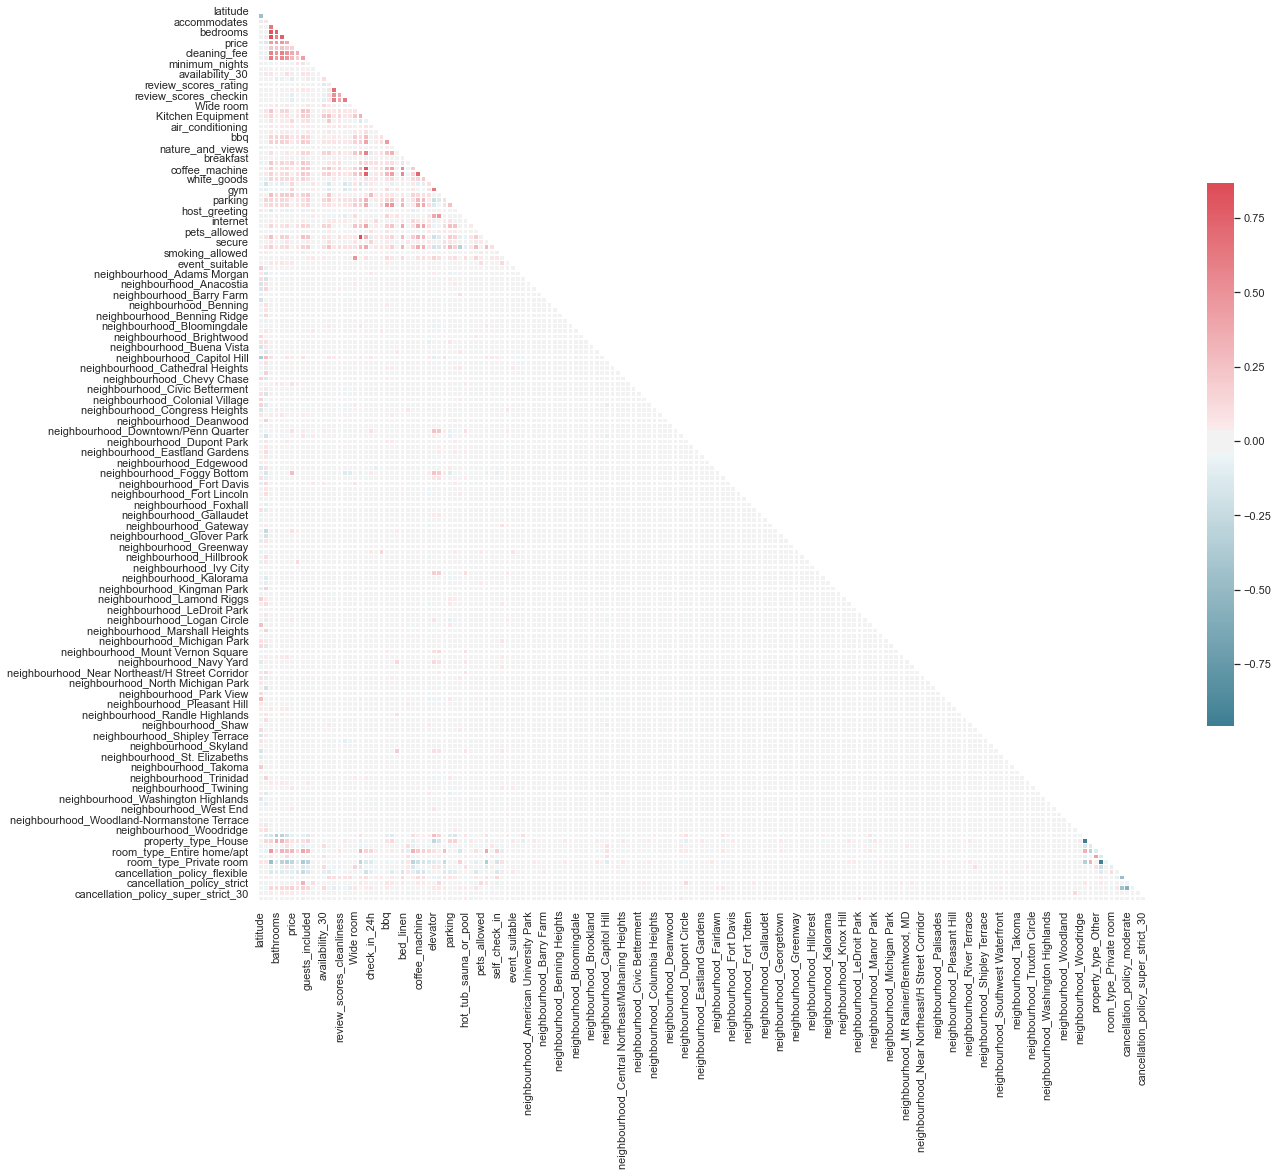

In [28]:
sns.set(style="white")
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

In [29]:
num_col = ['accommodates', 'availability_30', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee', 'guests_included', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'security_deposit']

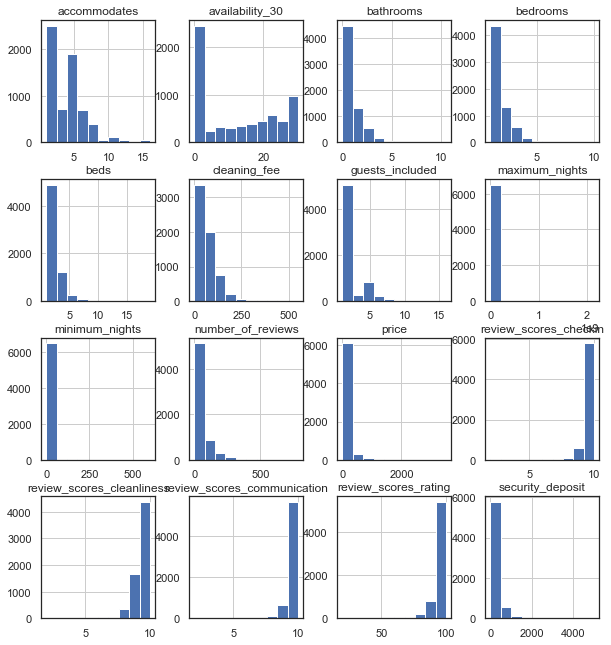

In [30]:
df[num_col].hist(figsize=(10,11));

This shows the graphs of some of the numerical columns that are a part of the graph. Just like the ones before, it is skewed in one side. Let's apply log transformation so that it'll have a better distribution.

In [31]:
#Here we are going to pick which columns we are going to keep. 
num_col = [i for i in num_col if i not in ['availability_30']]

for x in num_col:
    df[x] = df[x].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df[x] = np.log(df[x])

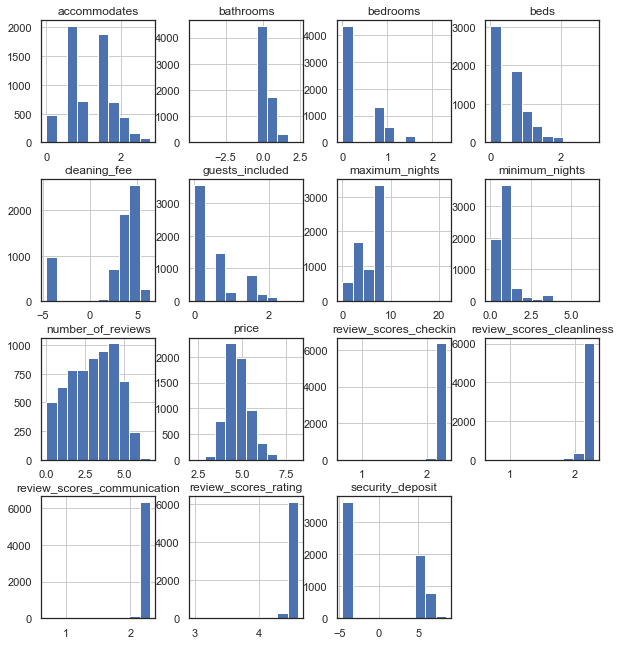

In [32]:
df[num_col].hist(figsize=(10,11));

By comparing the two sets of graphs above, we can see that by applying log transformation, it helped with the distribution of a graph by a significant amount. 

In [33]:
df.shape

(6496, 170)

In [34]:
df.to_csv('data_neural.csv')

Now that our data is all set and ready to go, we can finally apply our machine learning models on them. 

# Neural Network

We are going to apply different Neural Network Models and see what kind of results we can pull. 

## XGBoost and Feature Importance

Let's use XGBoost to weigh each feature and determine which ones are the most important.

In [35]:
X = df.drop('price', axis=1)
y = df.price

In [36]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=606)

In [38]:
#Create and fit the model
model1 = xgb.XGBRegressor()
model1.fit(X_train, y_train)
#Make predictions for both the test and training data
training = model1.predict(X_train)
validation = model1.predict(X_test)

#Print out results
print("\nTraining MSE:", round(mean_squared_error(y_train, training),4))
print("Test MSE:", round(mean_squared_error(y_test, validation),4))

print("\nTraining r2:", round(r2_score(y_train, training),4))
print("Test r2:", round(r2_score(y_test, validation),4))


Training MSE: 0.0336
Test MSE: 0.132

Training r2: 0.929
Test r2: 0.6999


In [39]:
weights = pd.DataFrame(model1.feature_importances_, columns=['weight'], index=X_train.columns)
weights.sort_values('weight', inplace=True)
weights

,weight
neighbourhood_Takoma,0.000000
neighbourhood_Bellevue,0.000000
neighbourhood_Benning,0.000000
neighbourhood_Buena Vista,0.000000
neighbourhood_Burleith,0.000000
...,...
room_type_Shared room,0.028537
bathrooms,0.029610
neighbourhood_Foggy Bottom,0.123984
bedrooms,0.163933


Here we see the feature importance of each variable based off of "weights". 

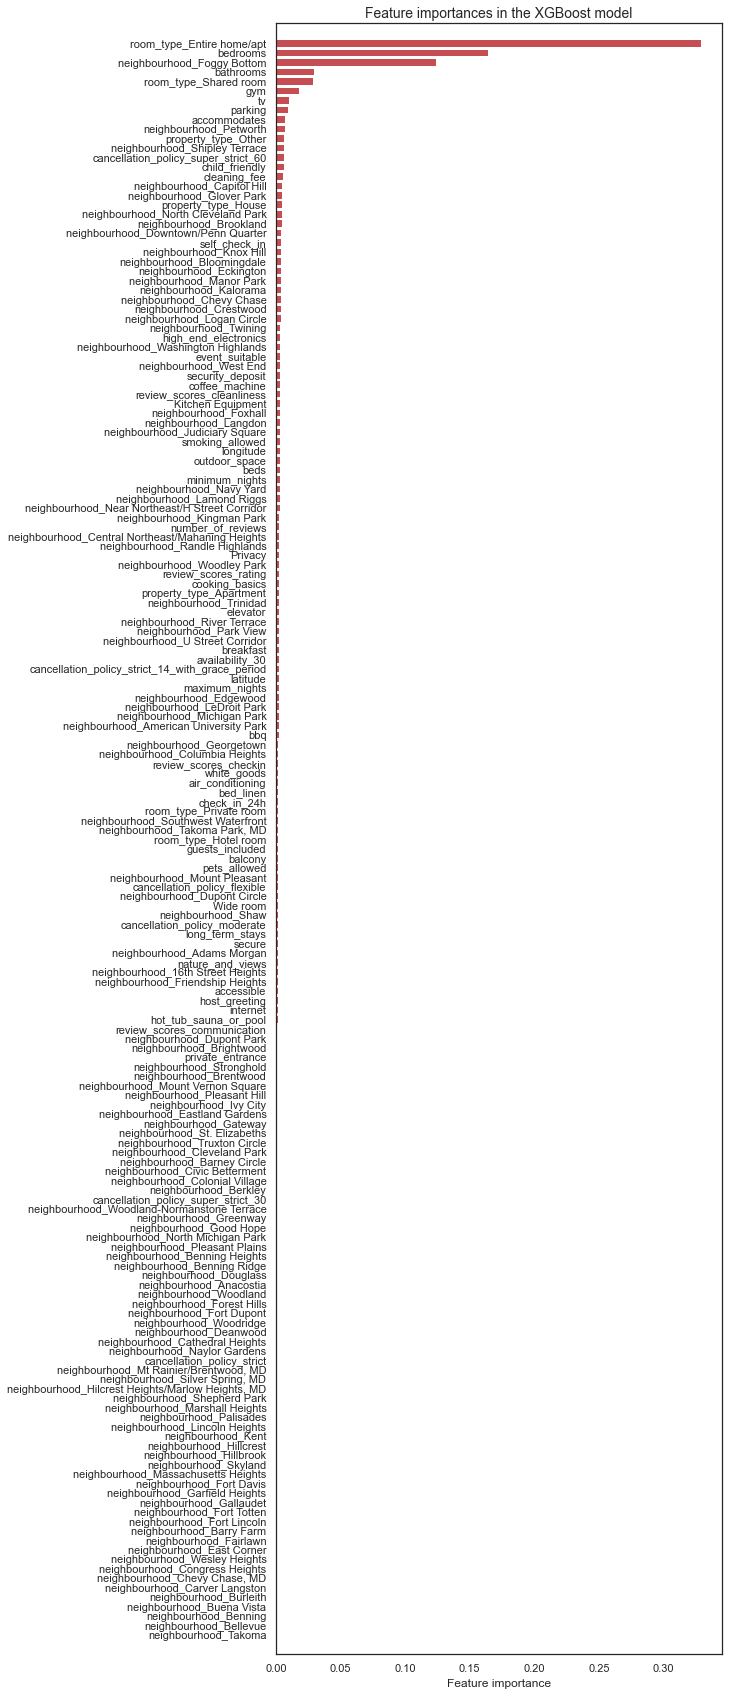

In [40]:
# Plotting feature importances
plt.figure(figsize=(8,30))
plt.barh(weights.index, weights.weight, align='center', color = 'r') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

Based on the XGBoost model, we can see that there are a number of features that have a significant amount of importance (the first 10). The rest have almost nothing. 

**The top 10 features in this dataset are:**

* Having the entire house/apt

* Whether the property is in Foggy bottoms

* The number of bedrooms

* The number of bathrooms

* Whether the property's room type is shared

* Whether the property has a gym

* Whether the property has a Television

* Whether the property is child_friendly

* Whether the property has parking

* The number of accomodations the property has





Also, with the training r2 being 0.9269 and the validation r2 being 0.6938, we can see that the model is fairly accurate. 

## Neural Network using three layers

Here I decide to create a deep learning model using neural networks. Here I am going to use a simple method of neural network, which is a neural network with three layers. Each layer is connected to each other by "edges", where each edge have weights associated with them. 

In [41]:
keras.utils.vis_utils.pydot = pydot

In [42]:
model2 = models.Sequential()
model2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='linear'))

model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

Once these layers are created, we are going to fit them into a model based on our current data. We are going to run it with 100 epochs. 

For those of you who aren't familiar with epochs, one epoch is when an entire dataset is passed through the neural network once. 

We are also going to set the batch size to 256. 

Also, we are going to use the adam optimization algorithm, which is popular due to its ability to receive good results. 

In [43]:
model2_test = model2.fit(X_train, y_train, epochs=100, batch_size=256, validation_split = 0.1)

Train on 4676 samples, validate on 520 samples
Epoch 1/100
4676/4676 [==============================] - 0s 47us/step - loss: 7.6429 - mean_squared_error: 7.6429 - val_loss: 3.0138 - val_mean_squared_error: 3.0138
Epoch 2/100
4676/4676 [==============================] - 0s 16us/step - loss: 1.8310 - mean_squared_error: 1.8310 - val_loss: 1.1012 - val_mean_squared_error: 1.1012
Epoch 3/100
4676/4676 [==============================] - 0s 17us/step - loss: 0.6592 - mean_squared_error: 0.6592 - val_loss: 0.5544 - val_mean_squared_error: 0.5544
Epoch 4/100
4676/4676 [==============================] - 0s 17us/step - loss: 0.3456 - mean_squared_error: 0.3456 - val_loss: 0.3775 - val_mean_squared_error: 0.3775
Epoch 5/100
4676/4676 [==============================] - 0s 19us/step - loss: 0.2656 - mean_squared_error: 0.2656 - val_loss: 0.3109 - val_mean_squared_error: 0.3109
Epoch 6/100
4676/4676 [==============================] - 0s 17us/step - loss: 0.2143 - mean_squared_error: 0.2143 - val_los

In [44]:
#This function will be used after every model (besides XGBoost). We are going to use this to calculate the MSE and r2 for both 
#of the training and validation set. Then we will create a scatterplot for both the training and test set.

def model_results(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    
    
    #Calculating the MSE and R2 values
    test_pred = model.predict(X_test)
    training_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, training_pred),4))
    print("Test MSE:", round(mean_squared_error(y_test, test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, training_pred),4))
    print("Test r2:", round(r2_score(y_test, test_pred),4))
    

    plt.subplots(1)
     #This will be the graph for the test set.
    plt.scatter(y_test, test_pred, s=2, alpha=0.7)
    plt.plot(list(range(2,8)), list(range(2,8)), color='black')
    plt.title('Test set')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    
    plt.subplots(1)
    #This will be the graph for the training set.
    plt.scatter(y_train, training_pred, s=2, alpha=0.7)
    plt.plot(list(range(2,8)), list(range(2,8)), color='black')
    plt.title('Train set')
    plt.xlabel('Actual values')
    plt.ylabel('Predicuted values')
  
    
    plt.show()

Training MSE: 0.024
Test MSE: 0.2751

Training r2: 0.9494
Test r2: 0.3745


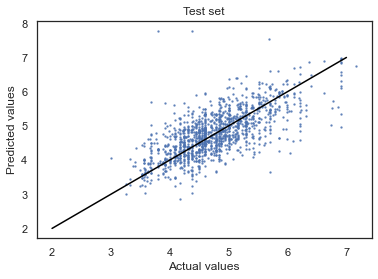

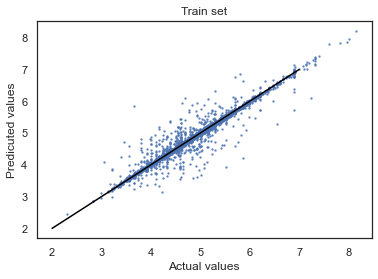

In [45]:
model_results(model2)

The validation set for this model is much, much worse than when we used XGBoost. However, the training set seemed to have performed better. A smaller MSE indicates a better estimate for the model. 

## Three Layer Neural Network with L1 Regularization

Here, we are going to create another three layer neural network, but using the L1 Regularization technique. The L1 Regularization technique penalize the absolute value of the weights, which is very good to compress our model. 

In [46]:
model3 = models.Sequential()
model3.add(layers.Dense(128, kernel_regularizer=regularizers.l1(0.001), input_shape=(X_train.shape[1],), activation='relu'))
model3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
model3.add(layers.Dense(1, activation='linear'))

model3.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [47]:
model3_test = model3.fit(X_train, y_train, epochs=100, batch_size=256, validation_split = 0.1)

Train on 4676 samples, validate on 520 samples
Epoch 1/100
4676/4676 [==============================] - 0s 47us/step - loss: 14.5902 - mean_squared_error: 7.5066 - val_loss: 10.2314 - val_mean_squared_error: 3.2717
Epoch 2/100
4676/4676 [==============================] - 0s 17us/step - loss: 8.9308 - mean_squared_error: 2.0719 - val_loss: 7.7996 - val_mean_squared_error: 1.0836
Epoch 3/100
4676/4676 [==============================] - 0s 18us/step - loss: 7.3449 - mean_squared_error: 0.7525 - val_loss: 6.9448 - val_mean_squared_error: 0.5113
Epoch 4/100
4676/4676 [==============================] - 0s 18us/step - loss: 6.7078 - mean_squared_error: 0.4069 - val_loss: 6.5144 - val_mean_squared_error: 0.3746
Epoch 5/100
4676/4676 [==============================] - 0s 19us/step - loss: 6.2911 - mean_squared_error: 0.2817 - val_loss: 6.1682 - val_mean_squared_error: 0.3121
Epoch 6/100
4676/4676 [==============================] - 0s 20us/step - loss: 5.9633 - mean_squared_error: 0.2286 - val_l

Training MSE: 0.0969
Test MSE: 0.1461

Training r2: 0.7954
Test r2: 0.6678


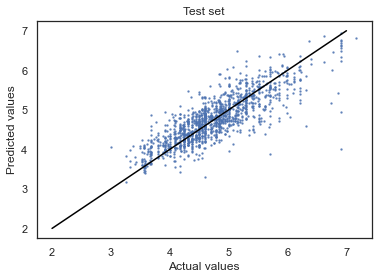

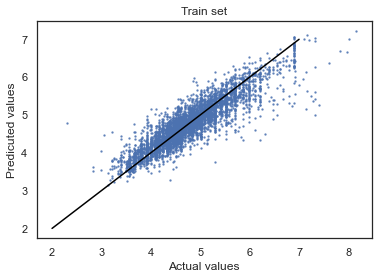

In [48]:
model_results(model3)

Here we see results isn't as bad as the normal neural network. Although the Training r2 is worse, the r2 for the validation set is much, much better. 

## Three Layer Neural Network with L2 Regularization

Next, let's try to use another three layer neural network, but using L2 Regularization instead. L2 regularization is known as a method for decaying weight, which it forces the weights to decay towards zero. 

In [49]:
model4 = models.Sequential()
model4.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train.shape[1],), activation='relu'))
model4.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model4.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model4.add(layers.Dense(1, activation='linear'))

model4.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [50]:
model4_test = model4.fit(X_train, y_train, epochs=100, batch_size=256, validation_split = 0.1)

Train on 4676 samples, validate on 520 samples
Epoch 1/100
4676/4676 [==============================] - 0s 99us/step - loss: 7.2471 - mean_squared_error: 6.6715 - val_loss: 2.7700 - val_mean_squared_error: 2.1923
Epoch 2/100
4676/4676 [==============================] - 0s 20us/step - loss: 2.0301 - mean_squared_error: 1.4512 - val_loss: 1.3375 - val_mean_squared_error: 0.7591
Epoch 3/100
4676/4676 [==============================] - 0s 29us/step - loss: 1.1396 - mean_squared_error: 0.5640 - val_loss: 1.0062 - val_mean_squared_error: 0.4350
Epoch 4/100
4676/4676 [==============================] - 0s 21us/step - loss: 0.9070 - mean_squared_error: 0.3406 - val_loss: 0.8982 - val_mean_squared_error: 0.3378
Epoch 5/100
4676/4676 [==============================] - 0s 22us/step - loss: 0.8111 - mean_squared_error: 0.2557 - val_loss: 0.8423 - val_mean_squared_error: 0.2930
Epoch 6/100
4676/4676 [==============================] - 0s 22us/step - loss: 0.7537 - mean_squared_error: 0.2094 - val_los

Training MSE: 0.0312
Test MSE: 0.2139

Training r2: 0.9342
Test r2: 0.5137


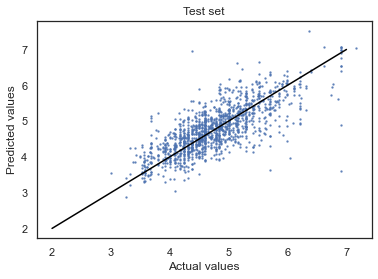

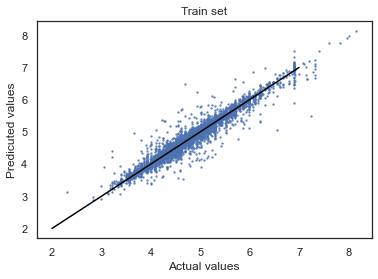

In [51]:
model_results(model4)

Compared to all the other models, the training r2 for this one is much higher. However, the validation r2 is very, very low. 

## Three Layer Neural Network with Dropout Regularization at 30%

For this model, I'm going to another three layer neural network and using the dropout regularization technique. Dropout is an interesting technique. At every iteration, dropout randomly selects nodes and removes them along with their incoming and outgoing connections. 

In [52]:
from keras.layers.core import Dropout

In [53]:
model5 = models.Sequential()
model5.add(layers.Dropout(0.3, input_shape=(X_train.shape[1],)))
model5.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model5.add(layers.Dropout(0.3))
model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.Dropout(0.3))
model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.Dropout(0.3))
model5.add(layers.Dense(1, activation='linear'))

model5.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [54]:
model5_test = model5.fit(X_train, y_train, epochs=100, batch_size=256, validation_split = 0.1)

Train on 4676 samples, validate on 520 samples
Epoch 1/100
4676/4676 [==============================] - 1s 116us/step - loss: 9.5762 - mean_squared_error: 9.5762 - val_loss: 6.9343 - val_mean_squared_error: 6.9343
Epoch 2/100
4676/4676 [==============================] - 0s 29us/step - loss: 4.0347 - mean_squared_error: 4.0347 - val_loss: 3.9362 - val_mean_squared_error: 3.9362
Epoch 3/100
4676/4676 [==============================] - 0s 27us/step - loss: 2.2617 - mean_squared_error: 2.2617 - val_loss: 2.2604 - val_mean_squared_error: 2.2604
Epoch 4/100
4676/4676 [==============================] - 0s 28us/step - loss: 1.6333 - mean_squared_error: 1.6333 - val_loss: 2.0811 - val_mean_squared_error: 2.0811
Epoch 5/100
4676/4676 [==============================] - 0s 33us/step - loss: 1.5411 - mean_squared_error: 1.5411 - val_loss: 2.2807 - val_mean_squared_error: 2.2807
Epoch 6/100
4676/4676 [==============================] - 0s 29us/step - loss: 1.3142 - mean_squared_error: 1.3142 - val_lo

Training MSE: 0.3115
Test MSE: 0.3063

Training r2: 0.3425
Test r2: 0.3036


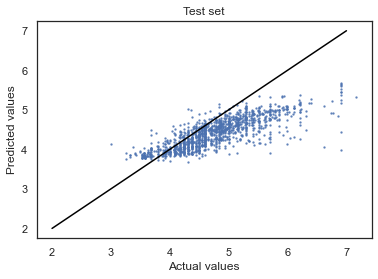

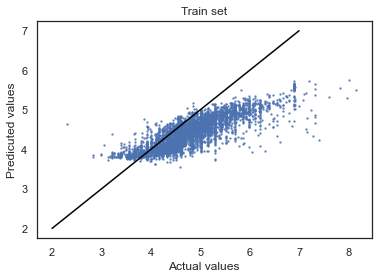

In [55]:
model_results(model5)

## Conclusion

Based on the five models I have worked on, it seems that XGBoost worked the best. 

Even though XGBoost was the highest out of all of them, the validation set still had a r2 of .6938. This means that the best model that we used (XGBoost) was only able to explain about 69% of the price we're trying to estimate. The other 31% could be from data that I removed in the beginning (The columns I viewed as unnecessary for the project). 

Additional work I wanted to work on, but didn't have enough time for, would be to use maps to show where in Washington D.C. most of the properties are located, and to use pictures as a way to determine price. 